# Parameter learning with Pandas

This notebook uses pandas to learn the parameters. However **<font color="red"><big>the simplest way to learn parameters is to use `BNLearner` :-)</big></font>**. Moreover, you will be able to add priors, etc (see <A href="BNLearning.html">learning BN</A>).

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

In [1]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

import os

## Importing pyAgrum

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

## Loading two BNs

In [3]:
bn=gum.loadBN("res/asia.bif")
bn2=gum.loadBN("res/asia.bif")

gnb.sideBySide(bn,bn2,
               captions=['First bn','Second bn'])

## Randomizing the parameters

In [4]:
bn.generateCPTs()
bn2.generateCPTs()

## Direct comparison of parameters

In [5]:
from IPython.display import HTML

gnb.sideBySide(bn.cpt(3),
               bn2.cpt(3),
               captions=['<h3>cpt of node 3 in first bn</h3>','<h3>same cpt in second bn</h3>'])


## Exact KL-divergence

Since the BN is not too big, BruteForceKL can be computed ...

In [6]:
g1=gum.ExactBNdistance(bn,bn2)
before_learning=g1.compute()
print(f"klPQ computed : {before_learning['klPQ']}")

klPQ computed : 2.2546503278564747


Just to be sure that the distance between a BN and itself is 0 :

In [7]:
g0=gum.ExactBNdistance(bn,bn)
print(g0.compute()['klPQ'])

0.0


## Generate a database from the original BN

In [8]:
gum.generateSample(bn,10000,"out/test.csv",True)

out/test.csv: 100%|████████████████████████████████████████|

Log2-Likelihood : -67523.96704586632


-67523.96704586632

## Using pandas for _counting

As an exercise, we will use pandas to learn the parameters.

In [9]:
# using bn as a template for the specification of variables in test.csv
learner=gum.BNLearner("out/test.csv",bn)
bn3=learner.learnParameters(bn.dag())

#the same but we add a Laplace adjustment (smoothing) as a Prior
learner=gum.BNLearner("out/test.csv",bn)
learner.useSmoothingPrior(1000) # a count C is replaced by C+1000
bn4=learner.learnParameters(bn.dag())

after_pyAgrum_learning=gum.ExactBNdistance(bn,bn3).compute()
after_pyAgrum_learning_with_smoothing=gum.ExactBNdistance(bn,bn4).compute()
print("without prior:{}".format(after_pyAgrum_learning['klPQ']))
print("with prior smooting(1000):{}".format(after_pyAgrum_learning_with_smoothing['klPQ']))

without prior:0.0012612936718866127
with prior smooting(1000):0.2380765959282108


### Now, let's try to learn the parameters with pandas

In [10]:
import pandas

In [11]:
# We directly generate samples in a DataFrame
df,_=gum.generateSample(bn,10000,None,True)

100%|██████████████████████████████████████████████████████|

Log2-Likelihood : -67340.09766891408


In [12]:
df.head()

,visit_to_Asia,bronchitis,lung_cancer,tuberculos_or_cancer,tuberculosis,positive_XraY,smoking,dyspnoea
0,1,0,0,1,1,0,0,1
1,1,1,1,1,0,0,1,1
2,1,1,1,1,1,0,1,0
3,0,0,1,1,0,1,1,1
4,1,0,1,1,1,0,1,1


We use the crosstab function in pandas

In [13]:
c=pandas.crosstab(df['dyspnoea'],[df['tuberculos_or_cancer'],df['bronchitis']])
c

tuberculos_or_cancer     0           1      
bronchitis               0     1     0     1
dyspnoea                                    
0                     2245  1176   389  1392
1                      209   761  2683  1145

Playing with numpy reshaping, we retrieve the good form for the CPT from the pandas cross-table

In [14]:
gnb.sideBySide('<pre>'+str(np.array((c/c.sum().apply(np.float32)).transpose()).reshape(2,2,2))+'</pre>',
               bn.cpt(bn.idFromName('dyspnoea')),
               captions=["<h3>Learned parameters in crosstab","<h3>Original parameters in bn</h3>"])

## A global method for estimating Bayesian network parameters from CSV file using PANDAS

In [15]:
def computeCPTfromDF(bn,df,name):
    """
    Compute the CPT of variable "name" in the BN bn from the database df
    """
    id=bn.idFromName(name)
    parents=list(reversed(bn.cpt(id).names))
    domains=[bn.variableFromName(name).domainSize()
             for name in parents]
    parents.pop()

    if (len(parents)>0):
        c=pandas.crosstab(df[name],[df[parent] for parent in parents])
        s=c/c.sum().apply(np.float32)
    else:
        s=df[name].value_counts(normalize=True)

    bn.cpt(id)[:]=np.array((s).transpose()).reshape(*domains)

def ParametersLearning(bn,df):
    """
    Compute the CPTs of every varaible in the BN bn from the database df
    """
    for name in bn.names():
        computeCPTfromDF(bn,df,name)

In [16]:
ParametersLearning(bn2,df)

KL has decreased a lot (if everything's OK)

In [17]:
g1=gum.ExactBNdistance(bn,bn2)
print("BEFORE LEARNING")
print(before_learning['klPQ'])
print
print("AFTER LEARNING")
print(g1.compute()['klPQ'])

BEFORE LEARNING
2.2546503278564747
AFTER LEARNING
0.28525632834501574


And CPTs should be close

In [18]:
gnb.sideBySide(bn.cpt(3),
               bn2.cpt(3),
               captions=["<h3>Original BN","<h3>learned BN</h3>"])

## Influence of the size of the database on the quality of learned parameters

What is the effect of increasing the size of the database on the KL ? We expect that the KL decreases to 0.

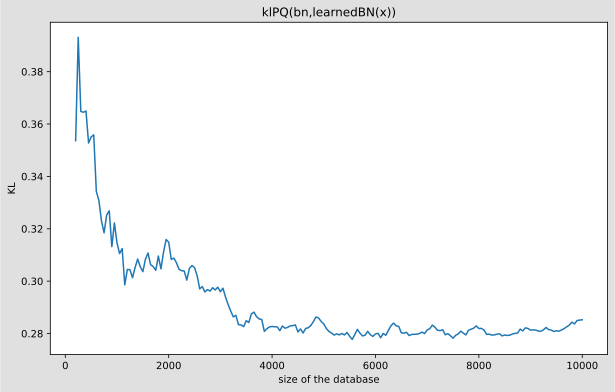

In [19]:
res=[]
for i in range(200,10001,50):
    ParametersLearning(bn2,df[:i])
    g1=gum.ExactBNdistance(bn,bn2)
    res.append(g1.compute()['klPQ'])
fig=figure(figsize=(10,6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(range(200,10001,50),res)
ax.set_xlabel("size of the database")
ax.set_ylabel("KL")
ax.set_title("klPQ(bn,learnedBN(x))");